# Plot decision boundary
> Can we plot decision boundaries?

In [1]:
%load_ext autoreload
%autoreload 2

# Plot the first decision boundary

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from geomstats.visualization import plot as gplot
from geomstats.geometry.hyperbolic import Hyperbolic

from sklearn.model_selection import train_test_split

# from src.hyperdt.toy_data import generate_gaussian_mixture_hyperboloid
from src.hyperdt.toy_data import wrapped_normal_mixture
from src.hyperdt.tree import HyperbolicDecisionTreeClassifier
from src.hyperdt.visualization import _get_geodesic, plot_tree, plot_boundary


INFO: Using numpy backend


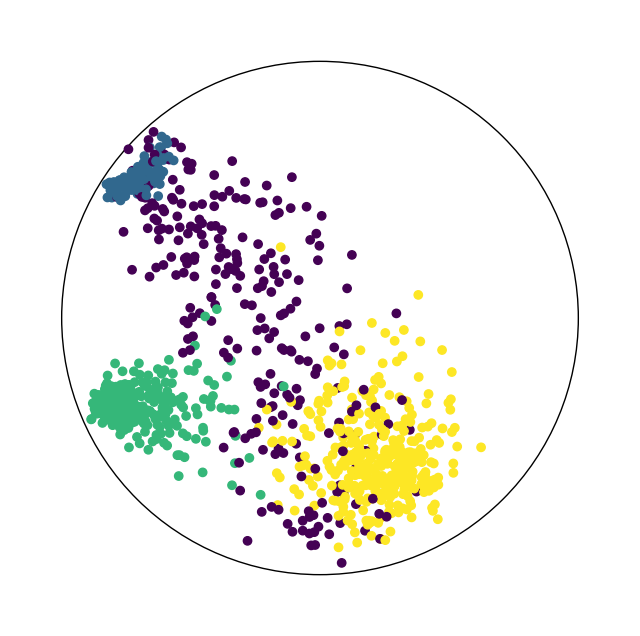

In [3]:
# Some data

X, y = wrapped_normal_mixture(
    num_points=1000, num_classes=4, noise_std=0.3, seed=2
)

# plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = gplot(X, c=y, space="H2_poincare_disk")
plt.show()


In [60]:
# Split into train and test sets; train HDT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

hdt = HyperbolicDecisionTreeClassifier(timelike_dim=0, max_depth=2)
hdt.fit(X_train, y_train)

hdt_score = hdt.score(X_test, y_test)
print(hdt_score)


0.735


# Use the plot_boundary() function:

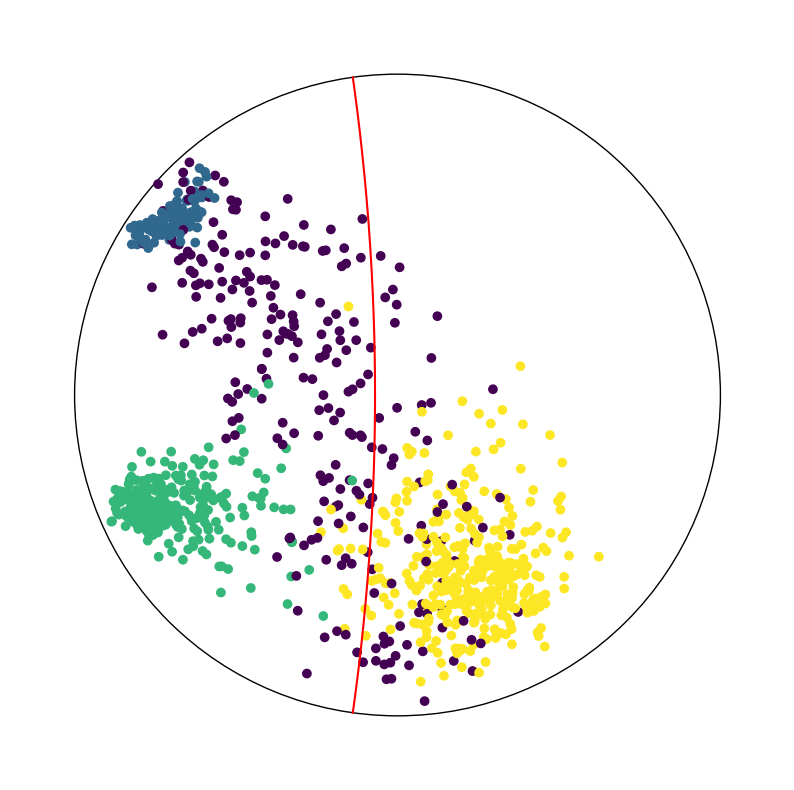

In [61]:
from src.hyperdt.visualization import plot_boundary

fig, ax = plt.subplots(figsize=(10, 10))
ax = gplot(X, c=y, space="H2_poincare_disk")
ax = plot_boundary(hdt.tree.feature, hdt.tree.theta, ax=ax)
plt.show()


# Plot subsequent boundaries:

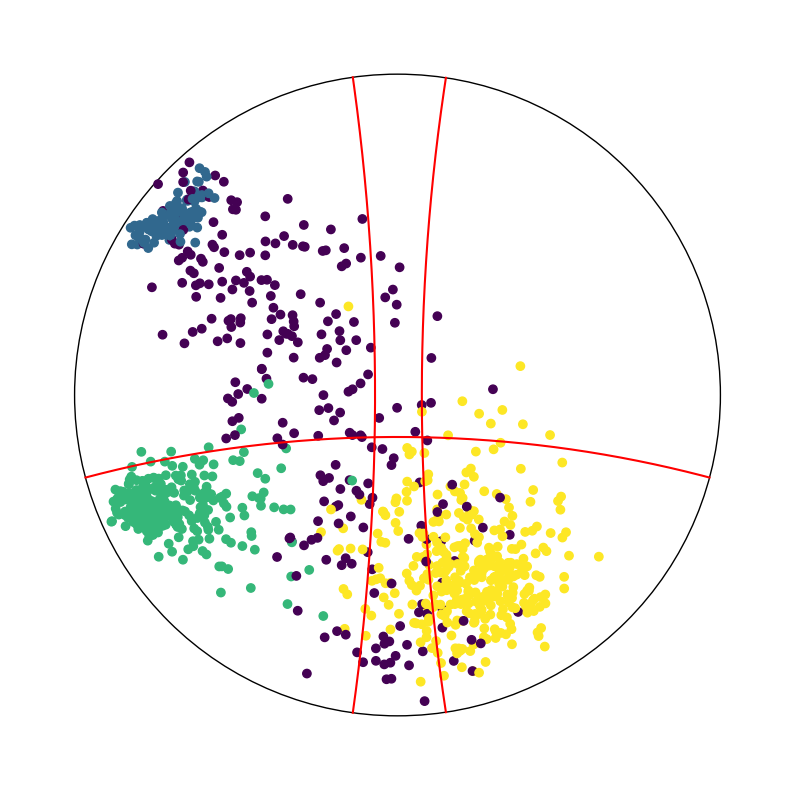

In [62]:
# We will need some kind of recursion later, but for now we just have depth 2
# so let's do it manually:

from src.hyperdt.visualization import _get_geodesic

fig, ax = plt.subplots(figsize=(10, 10))
ax = gplot(X, c=y, space="H2_poincare_disk")
ax = plot_boundary(hdt.tree.feature, hdt.tree.theta, geometry="poincare", ax=ax)
ax = plot_boundary(
    hdt.tree.left.feature, hdt.tree.left.theta, geometry="poincare", ax=ax
)
ax = plot_boundary(
    hdt.tree.right.feature, hdt.tree.right.theta, geometry="poincare", ax=ax
)


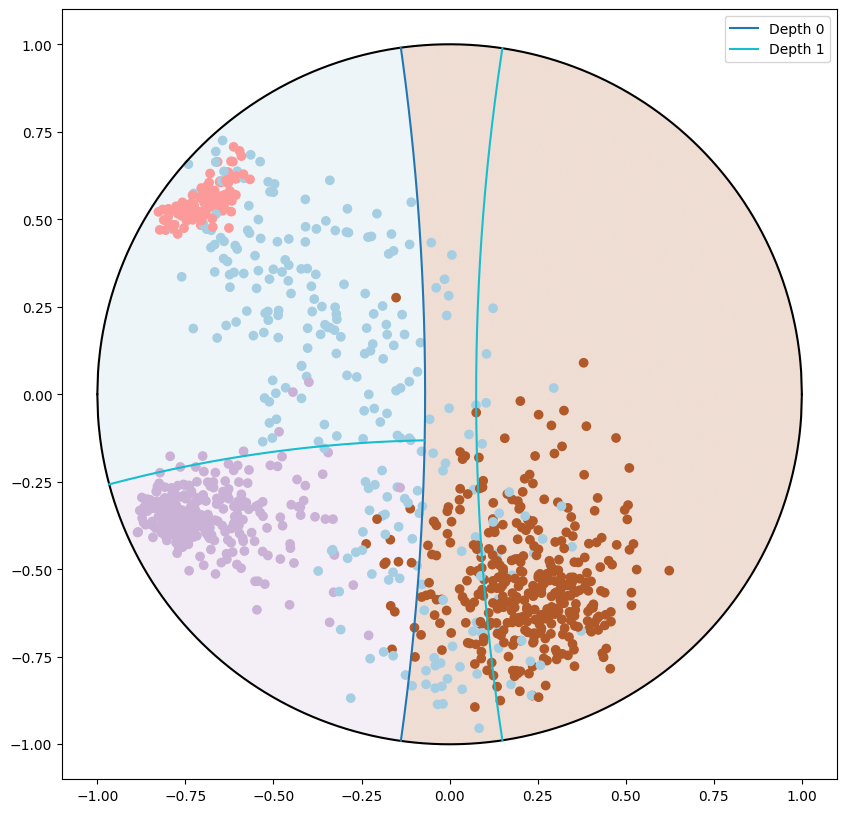

In [63]:
# Recursive version
from src.hyperdt.visualization import plot_tree

plot_tree(hdt, X=X, y=y)
plt.show()


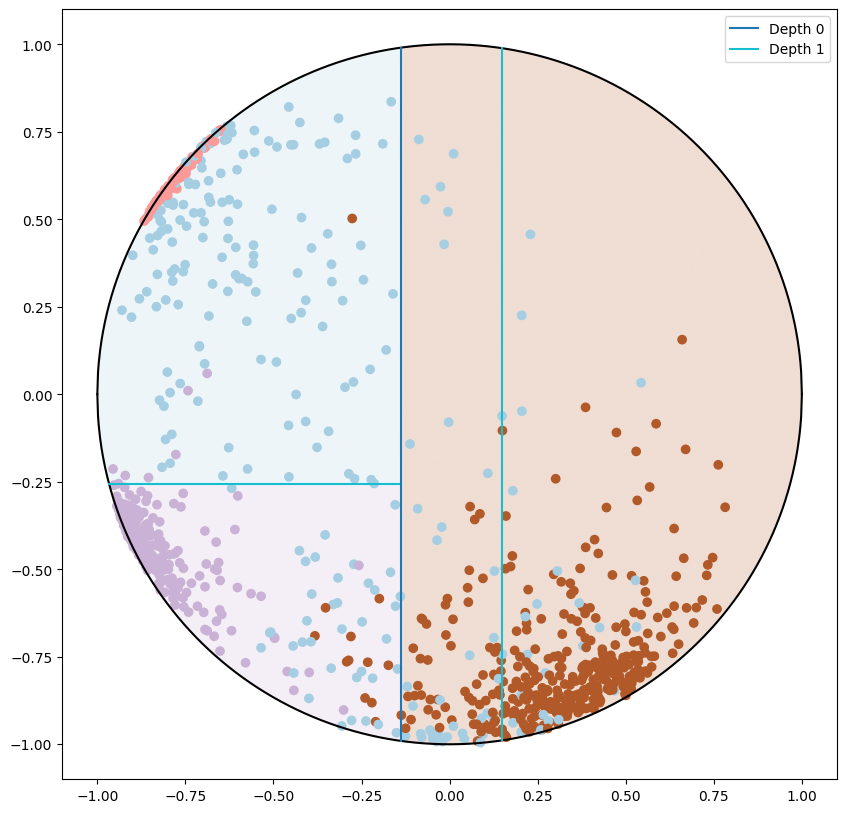

In [64]:
plot_tree(hdt, X=X, y=y, geometry="klein")
plt.show()


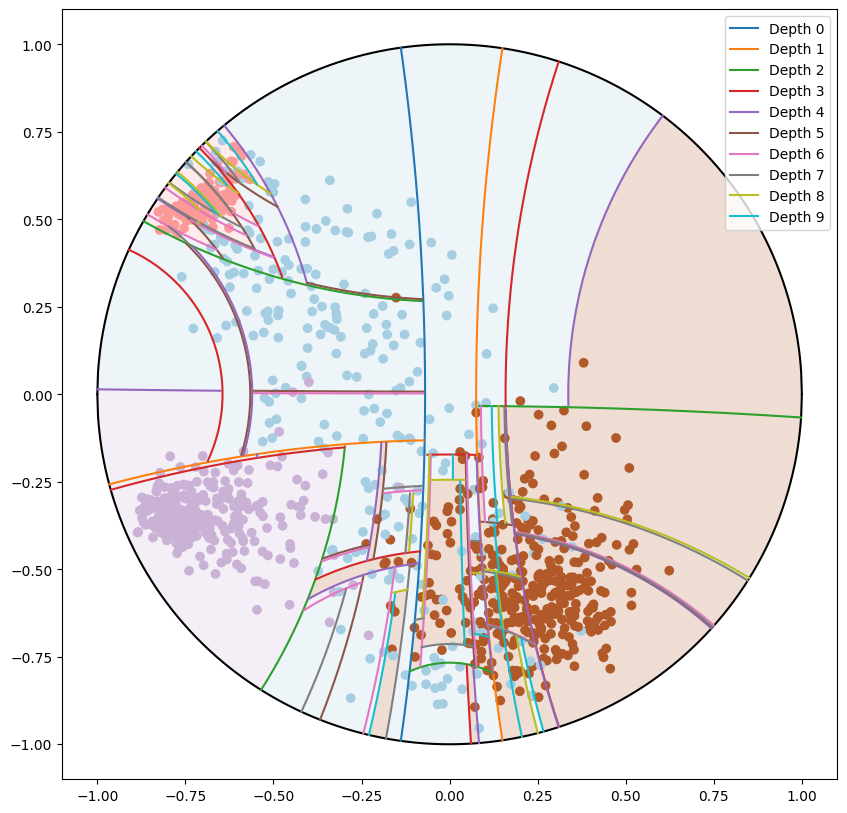

In [65]:
# Let's try this with a deep tree

hdt_deep = HyperbolicDecisionTreeClassifier(max_depth=10)
hdt_deep.fit(X_train, y_train)

plot_tree(hdt_deep, X=X, y=y)
plt.show()


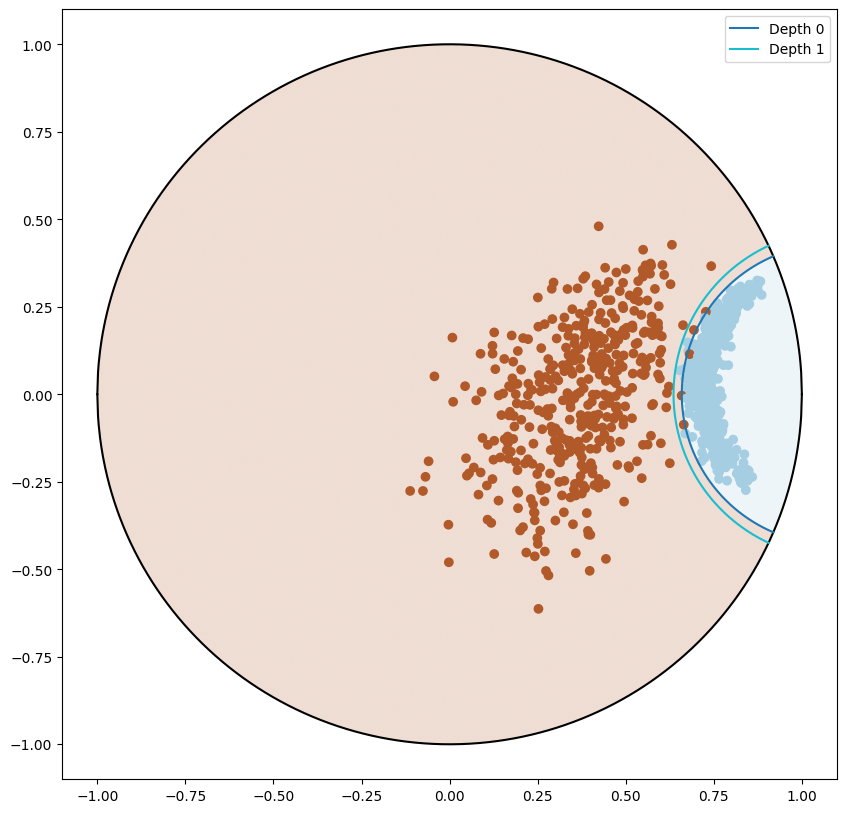

In [68]:
# Re-run this cell for infinite sanity checks

# Params
NUM_POINTS = 1000
NUM_CLASSES = 2
NOISE_STD = 0.1
MAX_DEPTH = 2

# Don't touch this:
# X_sanity, y_sanity = generate_gaussian_mixture_hyperboloid(
X_sanity, y_sanity = wrapped_normal_mixture(
    num_points=NUM_POINTS, num_classes=NUM_CLASSES, noise_std=NOISE_STD
)
X_sanity_train, X_sanity_test, y_sanity_train, y_sanity_test = train_test_split(
    X_sanity, y_sanity, test_size=0.2
)
hdt_sanity = HyperbolicDecisionTreeClassifier(max_depth=MAX_DEPTH)
hdt_sanity.fit(X_sanity_train, y_sanity_train)
plot_tree(hdt_sanity, X_sanity, y_sanity)
plt.show()


In [69]:
from src.hyperdt.visualization import _get_geodesic

geodesic = _get_geodesic(
    dim=hdt_sanity.tree.feature, theta=hdt_sanity.tree.theta, t_dim=2, n_dim=3
)


In [70]:
def val_to_index(val):
    """Convert a 2-place decimal to an index in (0, 200)"""
    assert val >= -1.0 and val <= 1.0
    val = np.round(val, 2)
    return int(val * 100) - 101


def apply_mask(x, y, mask):
    assert len(x) == len(y) == len(mask) == mask.shape[1] == 201
    x_out = []
    y_out = []
    for i, j in zip(x, y):
        # Note flipped coordinates:
        if mask[val_to_index(j), val_to_index(i)]:
            x_out.append(i)
            y_out.append(j)

    return np.array(x_out), np.array(y_out)


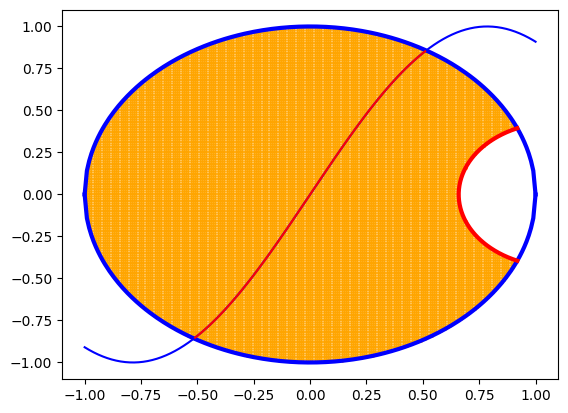

In [71]:
# How to mask our space? Need to use interp1d:

from scipy.interpolate import interp1d

_x = np.linspace(-1, 1, 201)
_y = np.linspace(-1, 1, 201)

y_circle = np.sqrt(1.0 - _x ** 2)
plt.plot(_x, y_circle, color="blue", linewidth=3)
plt.plot(_x, -y_circle, color="blue", linewidth=3)
plt.plot(geodesic[:, 0], geodesic[:, 1], color="red", linewidth=3)

# Get meshgrid going: 1000 x 1000 space
xx, yy = np.meshgrid(_x, _y)

# Mask 1: inside the circle
mask1 = np.linalg.norm(np.stack([xx, yy]), axis=0) <= 1

# Use interpolation. Since we have a geodesic along the x axis, we need to
# filter on the x coordinate:
geodesic_interp = interp1d(
    geodesic[:, 1],
    geodesic[:, 0],
    bounds_error=False,
    fill_value="extrapolate",
)
geodesic_x = geodesic_interp(yy)
mask2 = xx < geodesic_x

mask = mask1 & mask2

xx_plot = xx[mask]
yy_plot = yy[mask]

plt.scatter(xx_plot, yy_plot, color="orange", s=1)

# Can we restrict a plot to just the shaded region?
z = np.sin(_x * 2)
_x_masked, _z_masked = apply_mask(_x, z, mask)
plt.plot(_x, z, color="blue")
plt.plot(_x_masked, _z_masked, color="red")


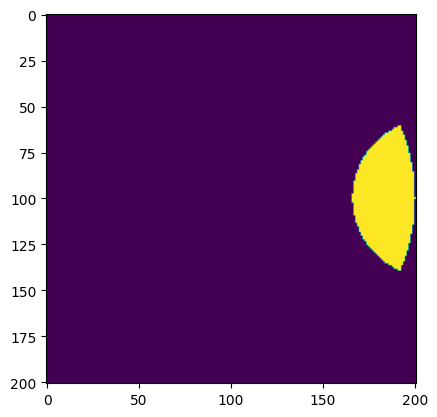

In [72]:
plt.imshow(mask1 & ~mask2)


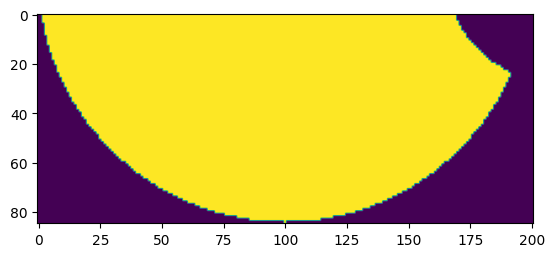

In [73]:
_x_masked  # caps at .16
plt.imshow(
    mask[
        val_to_index(0.16) :,
    ]
)


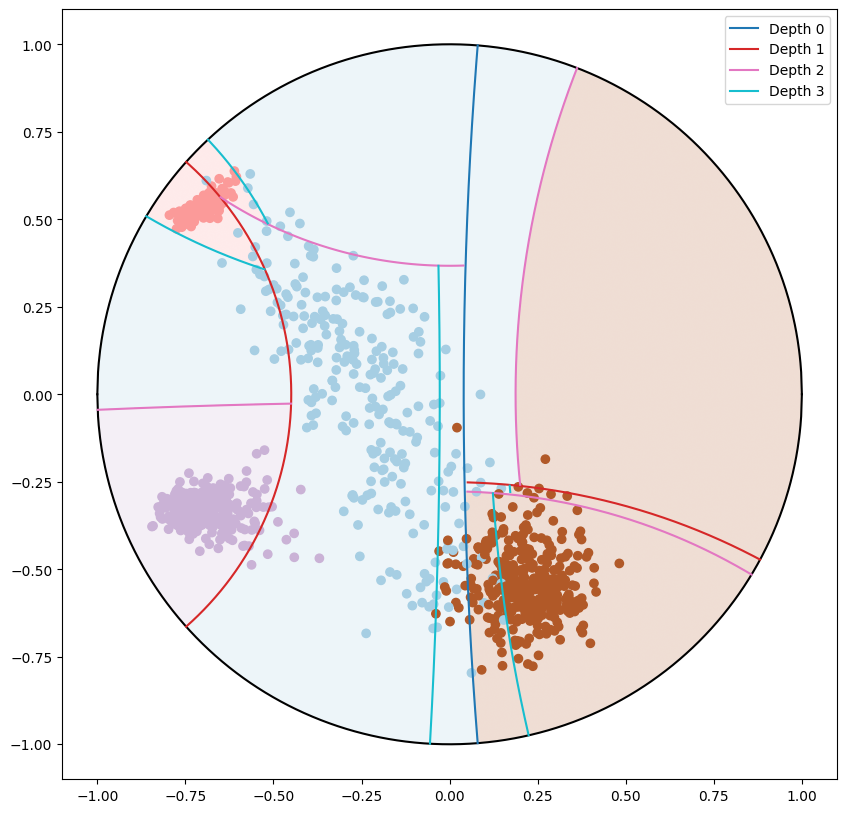

In [4]:
# Let's find a specific one where depth 0 and depth 1 are different dims:

# Don't touch this:
# X_cross, y_cross = generate_gaussian_mixture_hyperboloid(
X_cross, y_cross = wrapped_normal_mixture(
    num_points=1000, num_classes=4, noise_std=0.1, seed=2
)
hdt_cross = HyperbolicDecisionTreeClassifier(max_depth=4, candidates="data")
hdt_cross.fit(X_cross, y_cross)

plot_tree(hdt_cross, X=X_cross, y=y_cross)
plt.show()

# Great, now this works so I removed the cell that compares this ith a tree where
# candidates = "grid"


0.966


AssertionError: 

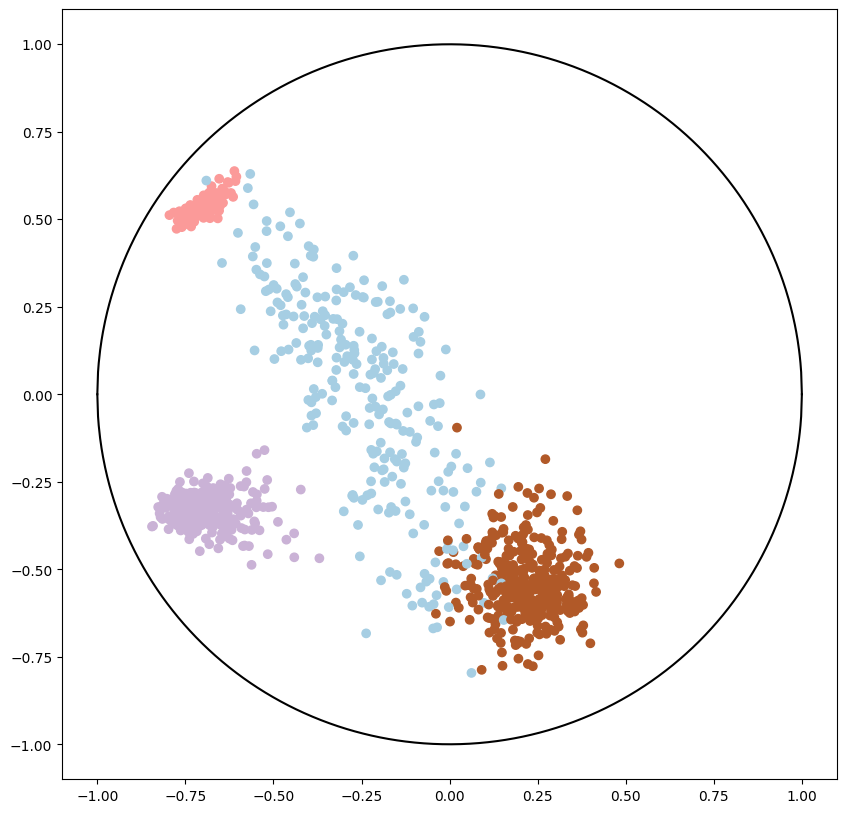

In [31]:
# What about Minkowski?

hdt_minkowski = HyperbolicDecisionTreeClassifier(
    max_depth=4, candidates="data", dot_product="sparse_minkowski"
)
hdt_minkowski.fit(X_cross, y_cross)
print(hdt_minkowski.score(X_cross, y_cross))

plot_tree(hdt_minkowski, X=X_cross, y=y_cross)
plt.show()


In [20]:
print(hdt_minkowski._get_candidates(X_cross, 1)[0], hdt_cross._get_candidates(X_cross, 1)[0])

Getting candidates
sparse_minkowski
Adjusting by pi/2
Getting candidates
sparse
2.5850207663084364 1.01422443951354


In [98]:
for t in [hdt_minkowski, hdt_cross]:
    for node in [
        t.tree,
        t.tree.left,
        t.tree.right,
        t.tree.left.left,
        t.tree.left.right,
        t.tree.right.left,
        t.tree.right.right,
        t.tree.left.left.left,
        t.tree.left.left.right,
    ]:
        print(node.feature, node.theta)
    print()


1 1.650200945917161
1 0.9284837146870735
2 1.129746907709843
2 1.3310101007326125
2 2.142352347605652
2 1.0951547964090544
1 1.7854246537293343
None None
2 2.0338589076168154

1 1.4912187285366467
1 2.2129354710665097
2 2.012073890629947
2 1.6151418318431758
2 0.996473619344276
2 2.046493896155719
1 1.2235703185296287
None None
2 1.1002900396411908



In [22]:
hdt_minkowski.score(X_cross, y_cross)

0.358

In [30]:
hdt_cross.score(X_cross, y_cross)

0.966